In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Load and preprocess prediction label data

Daily Natural Gas Prices:
                   Day  HH_Price
Date                            
1997-01-07   01/7/1997      3.82
1997-01-08   01/8/1997      3.80
1997-01-09   01/9/1997      3.61
1997-01-10  01/10/1997      3.92
1997-01-13  01/13/1997      4.00

Monthly Average Natural Gas Prices:
Date
1997-01-01    3.451053
1997-02-01    2.150526
1997-03-01    1.890500
1997-04-01    2.032727
1997-05-01    2.248095
Freq: MS, Name: HH_Price, dtype: float64


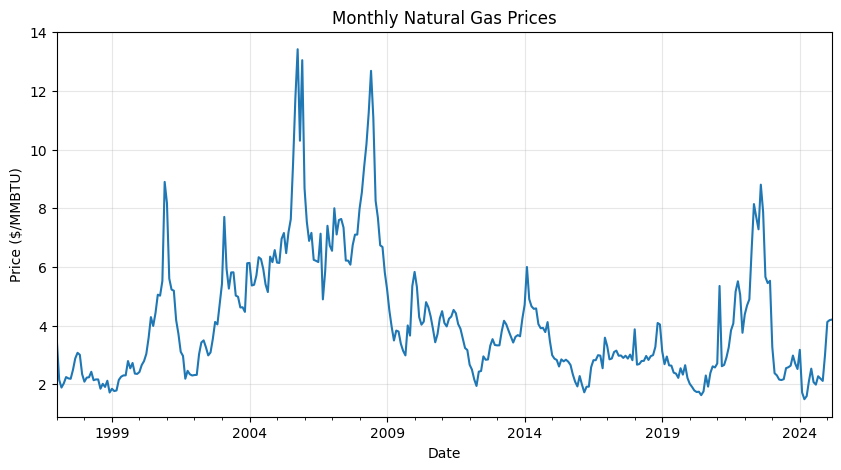

In [6]:

# Function to load and preprocess NG_SandF.csv
def preprocess_ng_prices(filepath='NG_SandF.csv'):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    header_row = next(i for i, line in enumerate(lines) if "Day" in line and "Henry Hub" in line)
    ng_df = pd.read_csv(filepath, skiprows=header_row)
    ng_df.columns = ng_df.columns.str.strip()
    
    price_col = [col for col in ng_df.columns if "Henry Hub" in col][0]
    ng_df = ng_df.rename(columns={price_col: "HH_Price"})
    
    ng_df['Date'] = pd.to_datetime(ng_df['Day'], format='%m/%d/%Y')
    ng_df['HH_Price'] = pd.to_numeric(ng_df['HH_Price'], errors='coerce')
    
    # Drop rows with missing prices
    ng_df = ng_df.dropna(subset=['HH_Price'])
    
    ng_df = ng_df.sort_values('Date').set_index('Date')
    monthly_ng = ng_df['HH_Price'].resample('MS').mean()
    
    return ng_df, monthly_ng

daily_prices, monthly_prices = preprocess_ng_prices('NG_SandF.csv')

print("Daily Natural Gas Prices:")
print(daily_prices.head())

print("\nMonthly Average Natural Gas Prices:")
print(monthly_prices.head())

monthly_prices.plot(figsize=(10, 5), title='Monthly Natural Gas Prices')
plt.ylabel('Price ($/MMBTU)')
plt.grid(True, alpha=0.3)
plt.show()

# Load and preprocess feature data used to predict Natural gas price


To use these functions, select from these metrics:
- 'Coal'
- 'Coal Production'
- 'Crude Oil Production'
- 'Crude Oil West Texas Intermediate Spot'
- 'Dry Natural Gas Production'
- 'Electricity'
- 'GDP Implicit Price Deflator'
- 'Liquid Fuels'
- 'Manufacturing Production Index'
- 'Natural Gas'
- 'Natural Gas Henry Hub Spot'
- 'Percent change from prior year'
- 'Real Disposable Personal Income'
- 'Real Gross Domestic Product'
- 'Renewables'
- 'Total Energy Consumption'
- 'U.S. Cooling Degree Days'
- 'U.S. Heating Degree Days'


/var/folders/b3/q80vb0m14p9fjtr908bjzvtm0000gn/T/ipykernel_9679/2753517733.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts_df['date'] = pd.to_datetime(ts_df['date'])


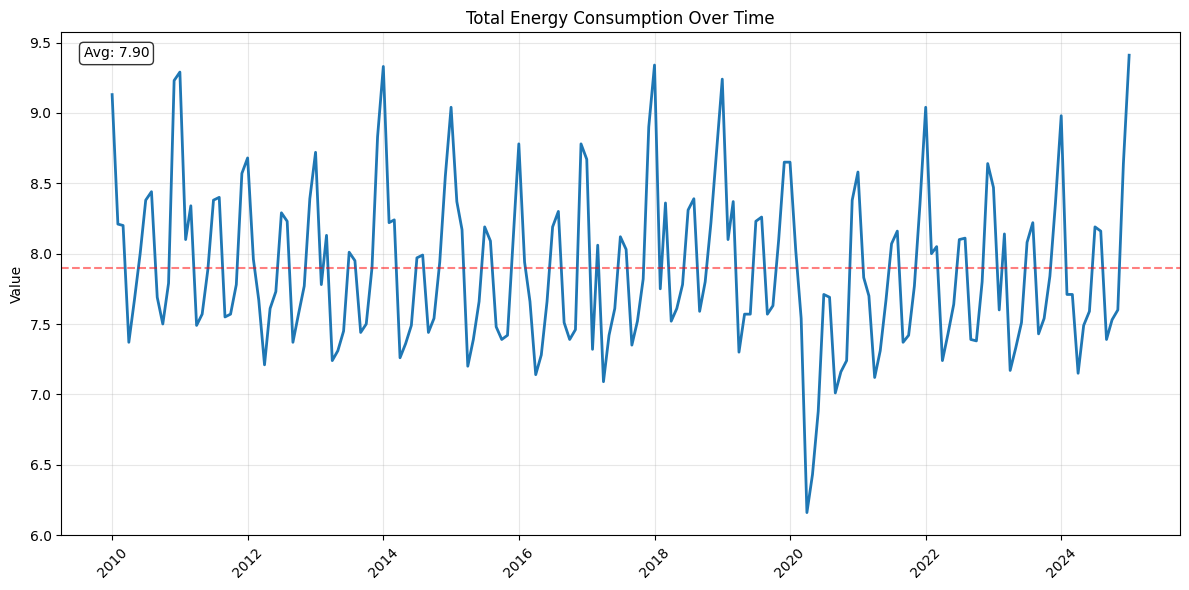

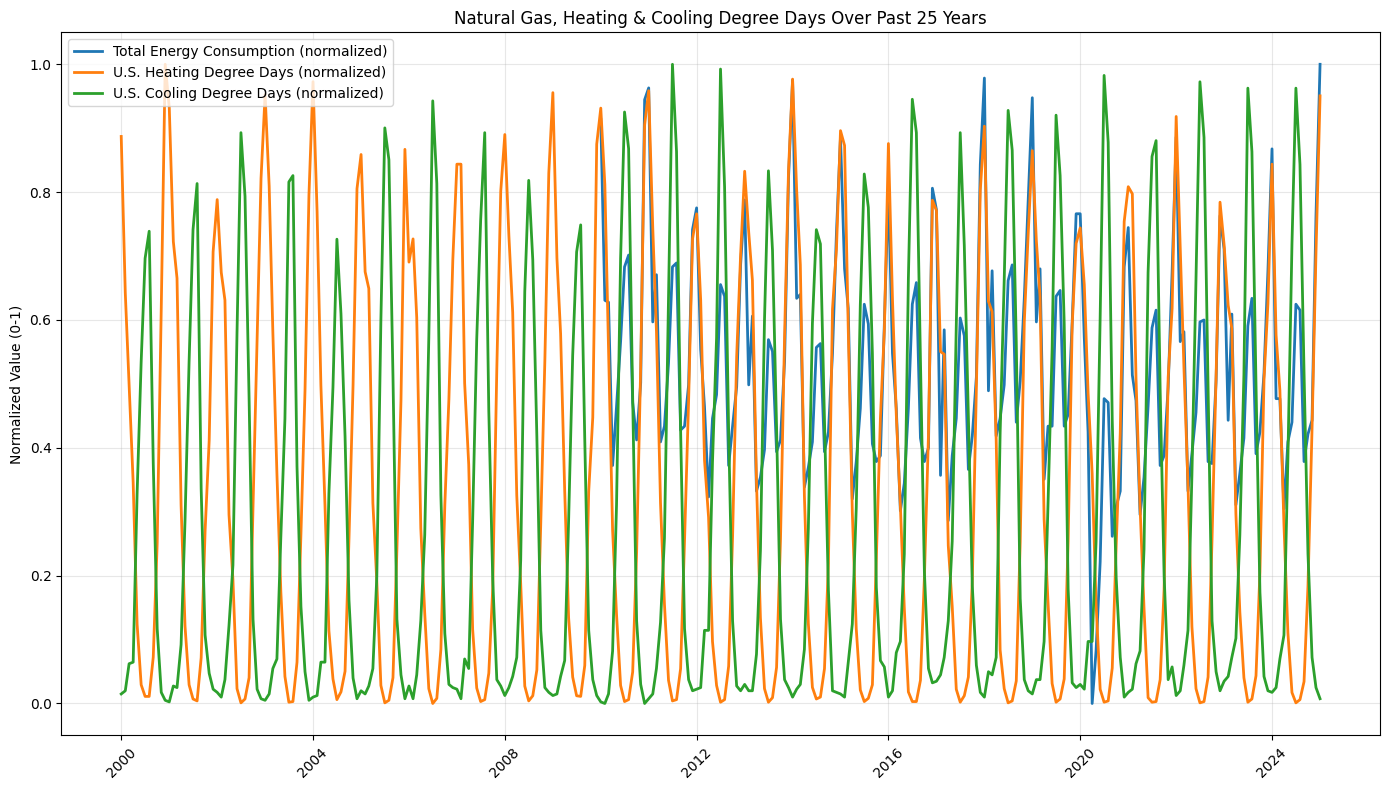

In [7]:

plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('USMonthlyEnergy.csv', skiprows=4)
df.columns = df.columns.str.strip('"\'')

# Step 3: Extract actual data rows (filter out headers and empty rows)
data_rows = df[~df['remove'].isin(['', 'Energy Production', '1. U.S. Energy Markets Summary'])].copy()
data_rows = data_rows[~data_rows['remove'].isna()]

date_columns = df.columns[6:]  # Based on file structure

# Create a list to hold transformed data
transformed_data = []

# Process each data row
for _, row in data_rows.iterrows():
    metric = row['remove']
    
    # Process each date column
    for date_col in date_columns:
        value = row[date_col]
        
        # Skip empty or missing values
        if pd.isna(value) or value == '' or value == '--':
            continue
            
        # Convert to numeric
        try:
            value = float(value)
        except (ValueError, TypeError):
            continue
            
        # Add to transformed data
        transformed_data.append({
            'date': date_col,  # Keep as string for now
            'metric': metric,
            'value': value
        })


ts_df = pd.DataFrame(transformed_data)
ts_df['date'] = pd.to_datetime(ts_df['date'])

ts_df = ts_df.set_index('date')

# Print summary information
# print(f"Time series data loaded successfully!")
# print(f"DataFrame shape: {ts_df.shape}")
# print(f"Date range: {ts_df.index.min()} to {ts_df.index.max()}")
# print(f"Available metrics:")
# for i, metric in enumerate(ts_df['metric'].unique(), 1):
#     print(f"  {i}. {metric}")

# Step 6: Visualization Functions

def plot_metric(metric_name, start_date=None, end_date=None, title=None, ylabel=None):
    """
    Plot a single energy metric over time.
    
    Parameters:
    metric_name (str): The name of the metric to plot
    start_date (str): Optional start date in format 'YYYY-MM-DD'
    end_date (str): Optional end date in format 'YYYY-MM-DD'
    title (str): Optional custom title
    ylabel (str): Optional y-axis label
    """
    df_subset = ts_df[ts_df['metric'] == metric_name]
    
    if start_date and end_date:
        df_subset = df_subset.loc[start_date:end_date]
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_subset.index, df_subset['value'], linewidth=2)
    plt.title(title or f'{metric_name} Over Time')
    plt.ylabel(ylabel or 'Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add some basic stats as annotations
    avg = df_subset['value'].mean()
    plt.axhline(y=avg, color='r', linestyle='--', alpha=0.5)
    plt.annotate(f'Avg: {avg:.2f}', 
                 xy=(0.02, 0.95), 
                 xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    return plt

def plot_multiple_metrics(metrics, start_date=None, end_date=None, title=None):
    """
    Plot multiple energy metrics on the same graph for comparison.
    
    Parameters:
    metrics (list): List of metric names to plot
    start_date (str): Optional start date in format 'YYYY-MM-DD'
    end_date (str): Optional end date in format 'YYYY-MM-DD'
    title (str): Optional custom title
    """
    plt.figure(figsize=(14, 8))
    
    for metric in metrics:
        df_subset = ts_df[ts_df['metric'] == metric]
        
        if start_date and end_date:
            df_subset = df_subset.loc[start_date:end_date]
            
        # Normalize values to better compare trends
        min_val = df_subset['value'].min()
        max_val = df_subset['value'].max()
        normalized = (df_subset['value'] - min_val) / (max_val - min_val)
        
        plt.plot(df_subset.index, normalized, label=f"{metric} (normalized)", linewidth=2)
    
    plt.title(title or 'Energy Metrics Comparison (Normalized)')
    plt.ylabel('Normalized Value (0-1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt

#plot_metric('Renewables', start_date='2010-01-01', end_date='2020-01-01', 
 #           title='Renewables Production Over Time', ylabel='Million BTU')
plot_metric('Total Energy Consumption', start_date='2000-01-01', end_date='2025-01-01',)
plot_multiple_metrics(['Total Energy Consumption', 'U.S. Heating Degree Days', 'U.S. Cooling Degree Days'], start_date='2000-01-01', end_date='2025-01-01',
                      title='Natural Gas, Heating & Cooling Degree Days Over Past 25 Years')

print("\nTo use these functions, select from these metrics:")
for metric in sorted(ts_df['metric'].unique()):
    print(f"- '{metric}'")

Monthly Natural Gas Prices:
Date
1997-01-01    3.451053
1997-02-01    2.150526
1997-03-01    1.890500
1997-04-01    2.032727
1997-05-01    2.248095
Freq: MS, Name: HH_Price, dtype: float64
Shape: (339,)
Date range: 1997-01-01 00:00:00 to 2025-03-01 00:00:00

Available energy metrics in ts_df:
['Crude Oil Production' 'Dry Natural Gas Production' 'Coal Production'
 'Liquid Fuels' 'Natural Gas' 'Coal' 'Electricity' 'Renewables'
 'Total Energy Consumption' 'Crude Oil West Texas Intermediate Spot'
 'Natural Gas Henry Hub Spot' 'Real Gross Domestic Product'
 'Percent change from prior year' 'GDP Implicit Price Deflator'
 'Real Disposable Personal Income' 'Manufacturing Production Index'
 'U.S. Heating Degree Days' 'U.S. Cooling Degree Days']

Using these metrics for analysis: ['Crude Oil Production', 'Dry Natural Gas Production', 'Coal Production', 'Liquid Fuels', 'Natural Gas', 'Electricity', 'Renewables', 'Total Energy Consumption', 'Crude Oil West Texas Intermediate Spot', 'Natural Gas He

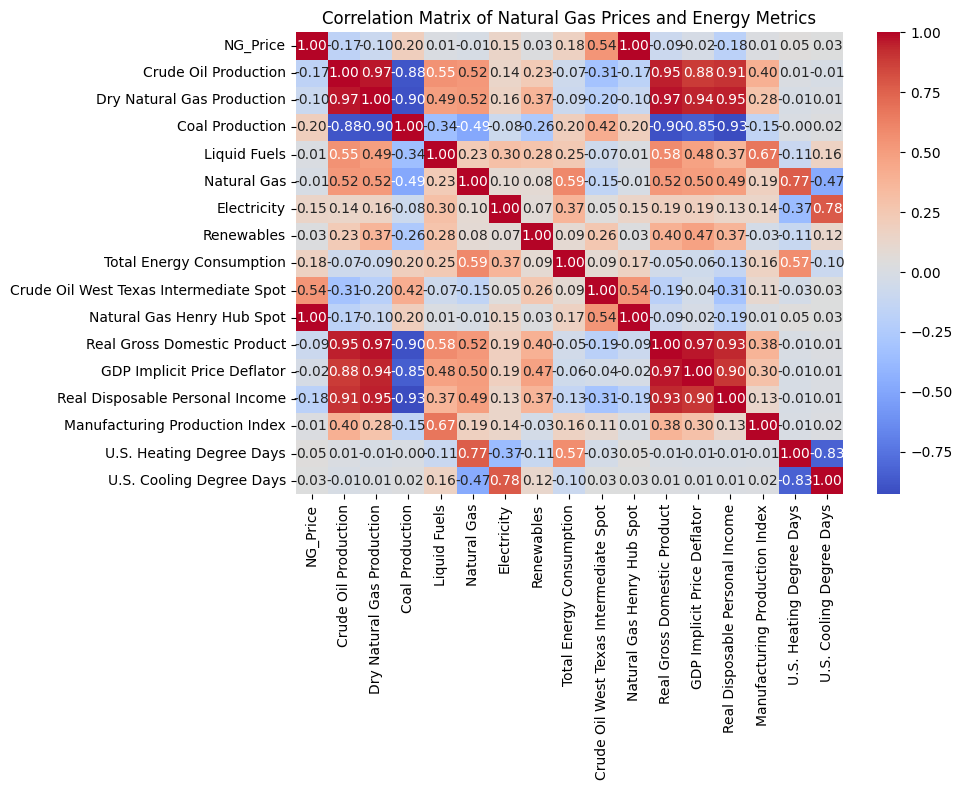

In [21]:


# Print summary of the dataframes we're working with
print("Monthly Natural Gas Prices:")
print(monthly_prices.head())
print(f"Shape: {monthly_prices.shape}")
print(f"Date range: {monthly_prices.index.min()} to {monthly_prices.index.max()}")

print("\nAvailable energy metrics in ts_df:")
print(ts_df['metric'].unique())

# se trelevant metrics from ts_df for the regression model

relevant_metrics = [
    'Crude Oil Production',
    'Dry Natural Gas Production',
    'Coal Production',
    'Liquid Fuels',
    'Natural Gas',
    'Electricity',
    'Renewables',
    'Total Energy Consumption',
    'Crude Oil West Texas Intermediate Spot',
    'Natural Gas Henry Hub Spot',
    'Real Gross Domestic Product',
    'GDP Implicit Price Deflator',
    'Real Disposable Personal Income',
    'Manufacturing Production Index',
    'U.S. Heating Degree Days',
    'U.S. Cooling Degree Days'
]

# Check which metrics are actually available in the data
available_metrics = ts_df['metric'].unique()
metrics_to_use = [m for m in relevant_metrics if m in available_metrics]
print(f"\nUsing these metrics for analysis: {metrics_to_use}")

#merge relevant metrics
merged_df = pd.DataFrame({'NG_Price': monthly_prices})

for metric in metrics_to_use:
    metric_data = ts_df[ts_df['metric'] == metric]['value']
    metric_data.name = metric
    merged_df = merged_df.join(metric_data, how='outer')

merged_df = merged_df.dropna()

print(f"\nCreated merged dataframe with {merged_df.shape[0]} rows and {merged_df.shape[1]} columns")
print(merged_df.head(10))


plt.figure(figsize=(10, 8))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Natural Gas Prices and Energy Metrics')
plt.tight_layout()
plt.show()




In [27]:
prediction_metrics = [
    'Coal Production',
    'Crude Oil West Texas Intermediate Spot',
    'Crude Oil Production',
    'Electricity',
    'Natural Gas'
]

# Check if these metrics exist in your merged dataframe
available_prediction_metrics = ['NG_Price'] + [col for col in prediction_metrics if col in merged_df.columns]

# Create a new dataframe with only these columns
prediction_df = merged_df[available_prediction_metrics].copy()


print(f"\nCreated prediction dataframe with {prediction_df.shape[0]} rows and {prediction_df.shape[1]} columns")
print(prediction_df.head())


Created prediction dataframe with 183 rows and 6 columns
            NG_Price  Coal Production  Crude Oil West Texas Intermediate Spot  \
2010-01-01  5.832105             86.0                                   78.33   
2010-02-01  5.320000             83.0                                   76.39   
2010-03-01  4.290870             97.0                                   81.20   
2010-04-01  4.033810             91.0                                   84.29   
2010-05-01  4.140000             85.0                                   73.74   

            Crude Oil Production  Electricity  Natural Gas  
2010-01-01                  5.40        11.06        90.64  
2010-02-01                  5.55        11.02        88.61  
2010-03-01                  5.52         9.79        69.13  
2010-04-01                  5.39         9.24        56.39  
2010-05-01                  5.40         9.49        52.17  



Regression Results:
Training RMSE: $1.06/MMBTU
Test RMSE: $1.01/MMBTU
Training R²: 0.2900
Test R²: 0.3893

Feature Coefficients:
                                  Feature  Coefficient
3                             Electricity     0.232978
1  Crude Oil West Texas Intermediate Spot     0.030824
4                             Natural Gas     0.005667
0                         Coal Production    -0.009952
2                    Crude Oil Production    -0.110123


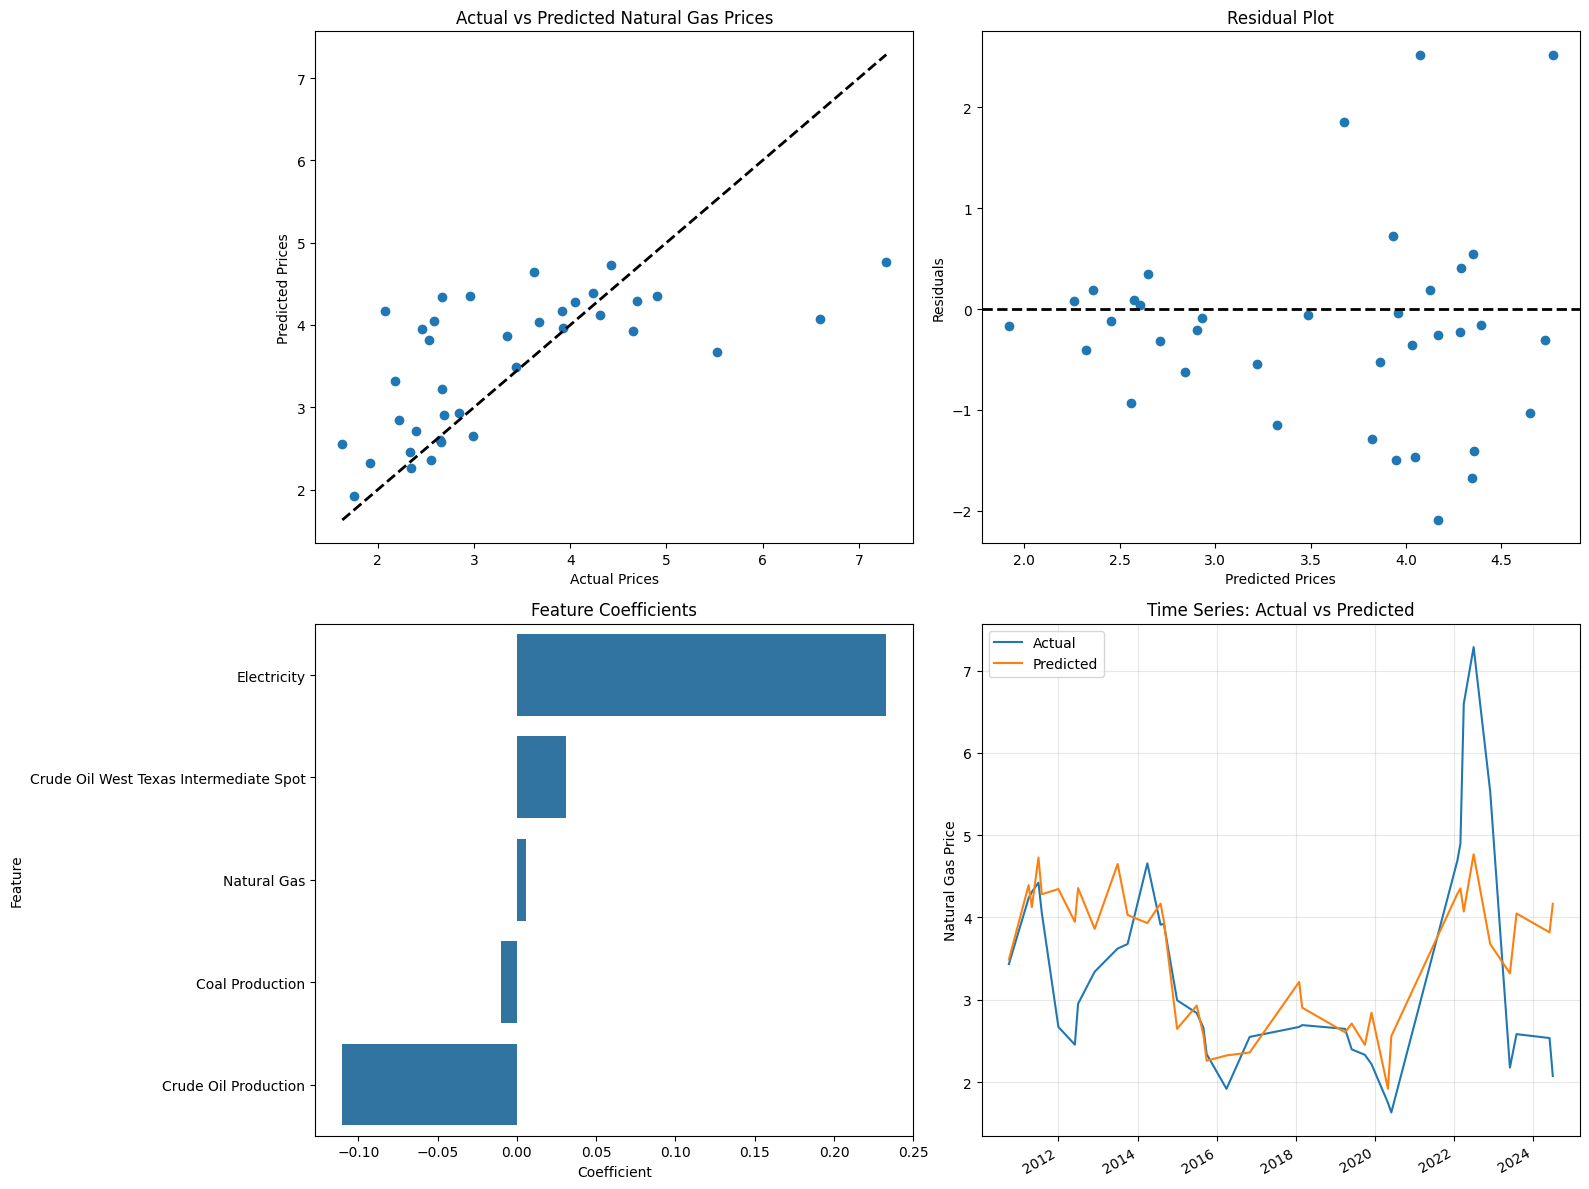


Standardized Feature Coefficients (for better comparison):
                                  Feature  Standardized_Coefficient
1  Crude Oil West Texas Intermediate Spot                  0.693089
3                             Electricity                  0.165526
4                             Natural Gas                  0.113399
0                         Coal Production                 -0.207508
2                    Crude Oil Production                 -0.266866


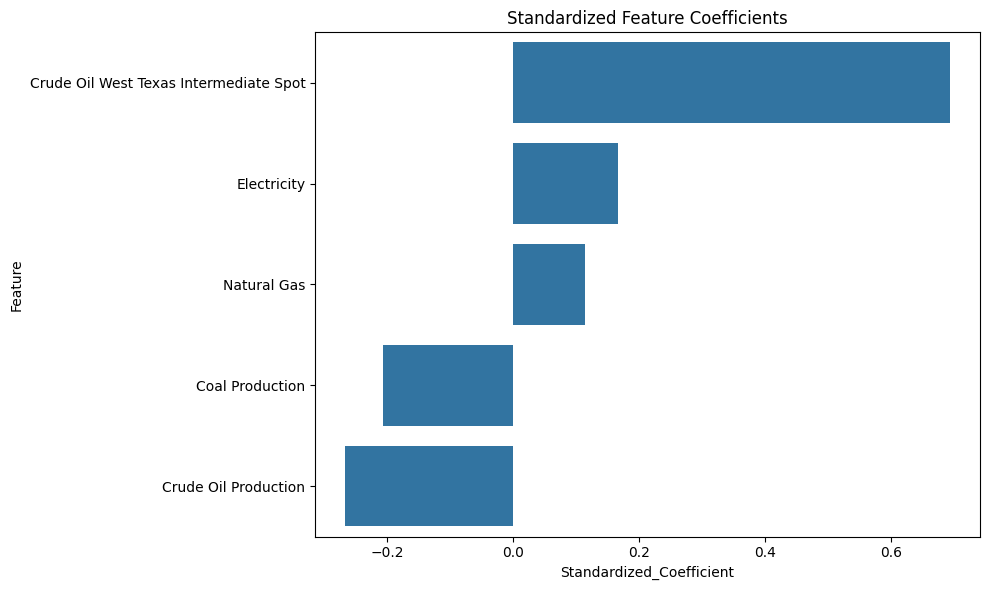

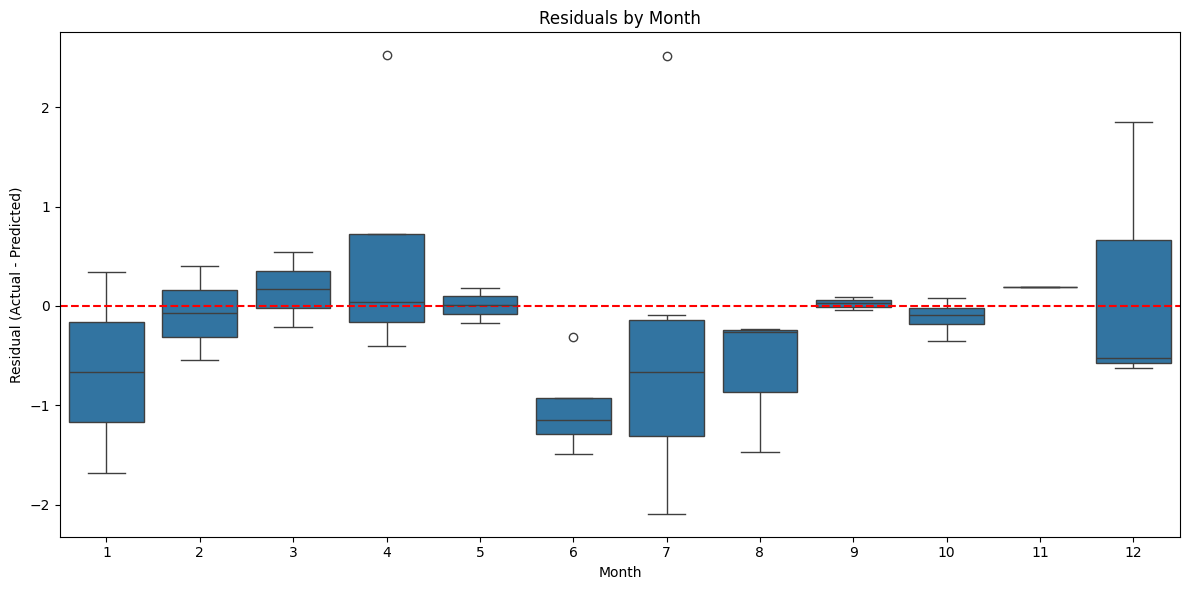

In [ ]:

X = prediction_df.drop(columns=['NG_Price'])
y = prediction_df['NG_Price']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Create coefficient summary
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
coef_df = coef_df.sort_values('Coefficient', ascending=False)

# Print regression results
print("\nRegression Results:")
print(f"Training RMSE: ${train_rmse:.2f}/MMBTU")
print(f"Test RMSE: ${test_rmse:.2f}/MMBTU")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

print("\nFeature Coefficients:")
print(coef_df)


#More plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test)
axes[0, 0].set_xlabel('Actual Prices')
axes[0, 0].set_ylabel('Predicted Prices')
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'k--', lw=2)
axes[0, 0].set_title('Actual vs Predicted Natural Gas Prices')

# Residual Plot
residuals = y_test - y_pred_test
axes[0, 1].scatter(y_pred_test, residuals)
axes[0, 1].set_xlabel('Predicted Prices')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].axhline(y=0, color='k', linestyle='--', lw=2)
axes[0, 1].set_title('Residual Plot')

#Coefficient Importance (weight)
sns.barplot(x='Coefficient', y='Feature', data=coef_df, ax=axes[1, 0])
axes[1, 0].set_title('Feature Coefficients')

# Plot 4: Time Series of Actual vs Predicted
if isinstance(y_test.index, pd.DatetimeIndex):
    # Sort by date for time series plot
    plot_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred_test
    }).sort_index()
    
    plot_df.plot(ax=axes[1, 1])
    axes[1, 1].set_title('Time Series: Actual vs Predicted')
    axes[1, 1].set_ylabel('Natural Gas Price')
    axes[1, 1].grid(True, alpha=0.3)
else:
    # If not time series, show distribution
    sns.kdeplot(y_test, ax=axes[1, 1], label='Actual')
    sns.kdeplot(y_pred_test, ax=axes[1, 1], label='Predicted')
    axes[1, 1].set_title('Distribution: Actual vs Predicted')
    axes[1, 1].set_xlabel('Natural Gas Price')
    
plt.tight_layout()
plt.show()



# Calculate standardized coefficients for better comparison
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Refit the model with scaled features
model_scaled = LinearRegression()
model_scaled.fit(X_scaled, y)

# Create standardized coefficient summary
std_coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Standardized_Coefficient': model_scaled.coef_
})
std_coef_df = std_coef_df.sort_values('Standardized_Coefficient', ascending=False)

print("\nStandardized Feature Coefficients (for better comparison):")
print(std_coef_df)

# Visualize standardized coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Standardized_Coefficient', y='Feature', data=std_coef_df)
plt.title('Standardized Feature Coefficients')
plt.tight_layout()
plt.show()

# Step 8: Seasonal analysis
# Check if we can extract seasonal patterns from the residuals
if isinstance(residuals.index, pd.DatetimeIndex):
    # Add month information to residuals
    residuals_df = pd.DataFrame({'residuals': residuals})
    residuals_df['month'] = residuals_df.index.month
    
    # Plot residuals by month
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='month', y='residuals', data=residuals_df)
    plt.title('Residuals by Month')
    plt.xlabel('Month')
    plt.ylabel('Residual (Actual - Predicted)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()